<a href="https://colab.research.google.com/github/KimJisanER/medical_ai/blob/main/stylegan2ada_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

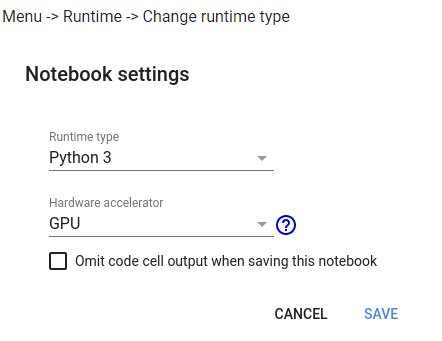

In [1]:
#할당된 gpu 확인
!nvidia-smi

# 런타임 유형을 GPU로 설정하지 않으면 아래 문구가 뜸
#NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

Tue Aug  9 13:42:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#현재 경로에 있는 파일이 무엇이 있는지 확인해보기(아래 코드를 받고 난 후와 비교)
!ls

sample_data


In [3]:
# stylegan2-ada pytorch 공개 코드 가져오기
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 24.42 MiB/s, done.
Resolving deltas: 100% (57/57), done.


###### 코드 공식 사이트 구글에서 검색해서 확인해보기
https://github.com/NVlabs/stylegan2-ada-pytorch

In [4]:
#가져온 코드 확인하기
!ls

sample_data  stylegan2-ada-pytorch


In [5]:
#작업 위치를 코드 아래와 옮기기
import os
os.chdir('./stylegan2-ada-pytorch/')

In [6]:
!ls

calc_metrics.py  docker_run.sh	LICENSE.txt   style_mixing.py
dataset_tool.py  docs		metrics       torch_utils
dnnlib		 generate.py	projector.py  training
Dockerfile	 legacy.py	README.md     train.py


In [7]:
#필요한 파이썬 라이브러리 설치하기
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 195 kB 27.8 MB/s 
     |████████████████████████████████| 108 kB 86.0 MB/s 
     |████████████████████████████████| 26.9 MB 1.4 MB/s 


In [8]:
!pip install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2 torchtext==0.8.1 tensorboard==1.14.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.8 MB 15 kB/s 
     |████████████████████████████████| 12.8 MB 77.3 MB/s 
     |████████████████████████████████| 7.6 MB 26.0 MB/s 
     |████████████████████████████████| 7.0 MB 98.7 MB/s 
     |████████████████████████████████| 3.1 MB 78.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0+cu113
    Uninstalling torch-1.12.0+cu113:
      Successfully uninstalled torch-1.12.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.0+cu113
    Uninstalling torchvision-0.13.0+cu113:
      Successfully uninstalled torchvision-0.13.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.0
    Uninstalling torchtext-0.13.0:
      Successfully uninstalled torchtext-0.13.0
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.

In [9]:
#필요한 라이브러리 불러오기
import torch
torch.cuda.device_count()
import torchvision

In [10]:
#핸즈온에 필요한 데이터 가져오기(데이터 권한: 프로메디우스(주)의 데이터이며, 본 핸즈온용으로 무료 배포)
!wget https://drive.promedius.dev/s/taD4StkwWPPWwXA/download/handson_stylegan2ada.zip

--2022-08-09 13:44:22--  https://drive.promedius.dev/s/taD4StkwWPPWwXA/download/handson_stylegan2ada.zip
Resolving drive.promedius.dev (drive.promedius.dev)... 112.169.219.65
Connecting to drive.promedius.dev (drive.promedius.dev)|112.169.219.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13660491 (13M) [application/zip]
Saving to: ‘handson_stylegan2ada.zip’

handson_stylegan2ad 100%[===================>]  13.03M  12.0MB/s    in 1.1s    

2022-08-09 13:44:24 (12.0 MB/s) - ‘handson_stylegan2ada.zip’ saved [13660491/13660491]



In [11]:
#받은 데이터 확인하기
!ls

calc_metrics.py  docs			   metrics	    training
dataset_tool.py  generate.py		   projector.py     train.py
dnnlib		 handson_stylegan2ada.zip  README.md
Dockerfile	 legacy.py		   style_mixing.py
docker_run.sh	 LICENSE.txt		   torch_utils


In [12]:
#데이터 압축풀기(총 500장의 흉부 X-ray이미지이며 인공지능 생성모델로 만든 합성이미지임)
!unzip handson_stylegan2ada.zip

Archive:  handson_stylegan2ada.zip
   creating: handson_stylegan2ada/
   creating: handson_stylegan2ada/promedius_cxr_500_for_stylegan2ada_128pixel/
  inflating: handson_stylegan2ada/promedius_cxr_500_for_stylegan2ada_128pixel/promedius_synthesized_cxr_000000.png  
  inflating: handson_stylegan2ada/promedius_cxr_500_for_stylegan2ada_128pixel/promedius_synthesized_cxr_000009.png  
  inflating: handson_stylegan2ada/promedius_cxr_500_for_stylegan2ada_128pixel/promedius_synthesized_cxr_000011.png  
  inflating: handson_stylegan2ada/promedius_cxr_500_for_stylegan2ada_128pixel/promedius_synthesized_cxr_000012.png  
  inflating: handson_stylegan2ada/promedius_cxr_500_for_stylegan2ada_128pixel/promedius_synthesized_cxr_000013.png  
  inflating: handson_stylegan2ada/promedius_cxr_500_for_stylegan2ada_128pixel/promedius_synthesized_cxr_000020.png  
  inflating: handson_stylegan2ada/promedius_cxr_500_for_stylegan2ada_128pixel/promedius_synthesized_cxr_000022.png  
  inflating: handson_stylegan2ad

In [13]:
#압축이 잘 풀렸는지 확인
!ls

calc_metrics.py  docs			   LICENSE.txt	    torch_utils
dataset_tool.py  generate.py		   metrics	    training
dnnlib		 handson_stylegan2ada	   projector.py     train.py
Dockerfile	 handson_stylegan2ada.zip  README.md
docker_run.sh	 legacy.py		   style_mixing.py


In [14]:
!ls handson_stylegan2ada

promedius_cxr_500_for_stylegan2ada_128pixel


In [15]:
imglist=os.listdir('handson_stylegan2ada/promedius_cxr_500_for_stylegan2ada_128pixel')#이미지 파일명을 imglist라는 변수에 담기
print(len(imglist))#이미지 개수 확인
print(imglist[:10])#샘플로 10개 이미지 파일명 확인

500
['promedius_synthesized_cxr_000218.png', 'promedius_synthesized_cxr_001293.png', 'promedius_synthesized_cxr_001464.png', 'promedius_synthesized_cxr_000571.png', 'promedius_synthesized_cxr_000325.png', 'promedius_synthesized_cxr_000782.png', 'promedius_synthesized_cxr_000996.png', 'promedius_synthesized_cxr_001062.png', 'promedius_synthesized_cxr_001589.png', 'promedius_synthesized_cxr_001408.png']


promedius_synthesized_cxr_000218.png


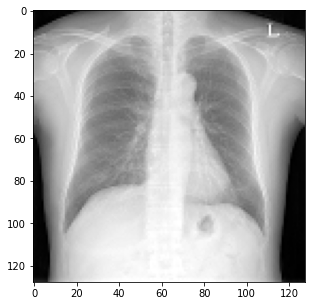

promedius_synthesized_cxr_001293.png


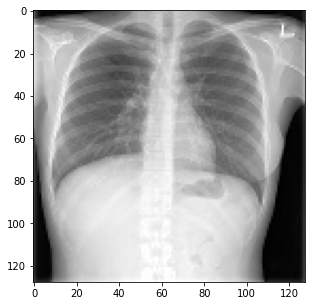

promedius_synthesized_cxr_001464.png


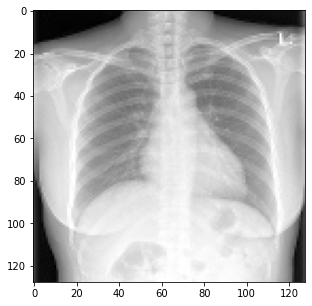

promedius_synthesized_cxr_000571.png


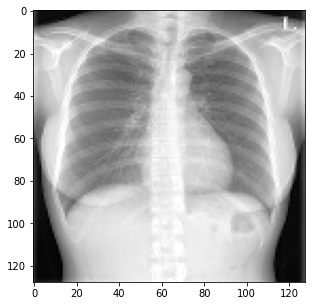

promedius_synthesized_cxr_000325.png


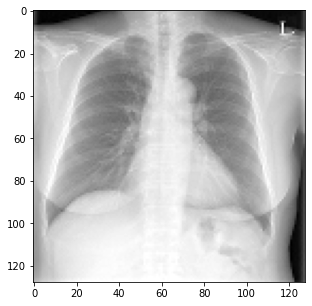

promedius_synthesized_cxr_000782.png


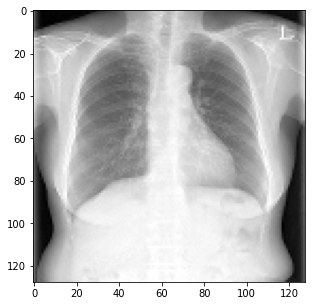

promedius_synthesized_cxr_000996.png


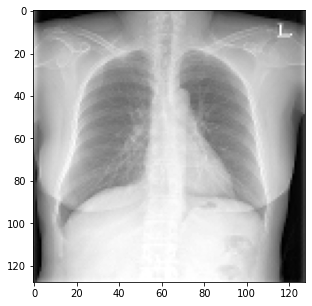

promedius_synthesized_cxr_001062.png


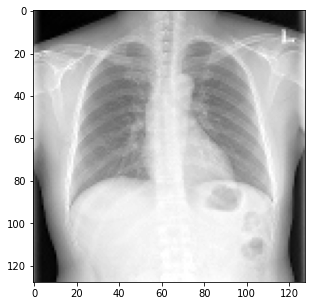

promedius_synthesized_cxr_001589.png


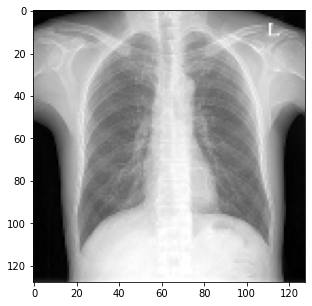

promedius_synthesized_cxr_001408.png


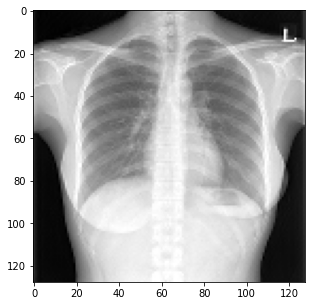

In [16]:
#샘플 이미지 10장을 디스플레이해보기
import cv2
import matplotlib.pyplot as plt

for tmp in range(10):
  img=cv2.imread(os.path.join('handson_stylegan2ada/promedius_cxr_500_for_stylegan2ada_128pixel', imglist[tmp]), 0)#이미지 읽기
  plt.figure(figsize=(5,5))
  print(imglist[tmp])#이미지 파일명 출력하기
  plt.imshow(img, cmap='gray')#이미지 디스플레이하기
  plt.show()

In [17]:
#Stylegan2ada에 맞는 입력 포맷으로 변환하기
!python dataset_tool.py --source=handson_stylegan2ada/promedius_cxr_500_for_stylegan2ada_128pixel --dest=handson_stylegan2ada/promedius_cxr_500_for_stylegan2ada_128pixel.zip

100% 500/500 [00:00<00:00, 549.31it/s]


In [18]:
#새로 만들어진 파일 확인하기
!ls handson_stylegan2ada

promedius_cxr_500_for_stylegan2ada_128pixel
promedius_cxr_500_for_stylegan2ada_128pixel.zip


In [19]:
#생성모델 학습하기
!python train.py --outdir=./results --data=handson_stylegan2ada/promedius_cxr_500_for_stylegan2ada_128pixel.zip --gpus=1 --augpipe=bg --gamma=10 --cfg=auto --mirror=0 --snap=10 --resume=ffhq256 


Training options:
{
  "num_gpus": 1,
  "image_snapshot_ticks": 10,
  "network_snapshot_ticks": 10,
  "metrics": [
    "fid50k_full"
  ],
  "random_seed": 0,
  "training_set_kwargs": {
    "class_name": "training.dataset.ImageFolderDataset",
    "path": "handson_stylegan2ada/promedius_cxr_500_for_stylegan2ada_128pixel.zip",
    "use_labels": false,
    "max_size": 500,
    "xflip": false,
    "resolution": 128
  },
  "data_loader_kwargs": {
    "pin_memory": true,
    "num_workers": 3,
    "prefetch_factor": 2
  },
  "G_kwargs": {
    "class_name": "training.networks.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "synthesis_kwargs": {
      "channel_base": 16384,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    }
  },
  "D_kwargs": {
    "class_name": "training.networks.Discriminator",
    "block_kwargs": {},
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "

###작업 로그 및 학습도중 저장된 모델 weight 확인해보기

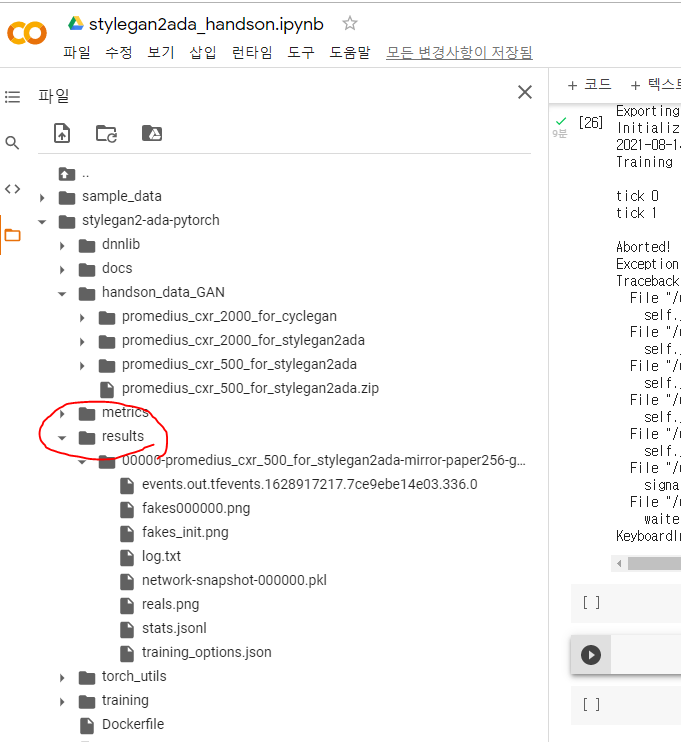

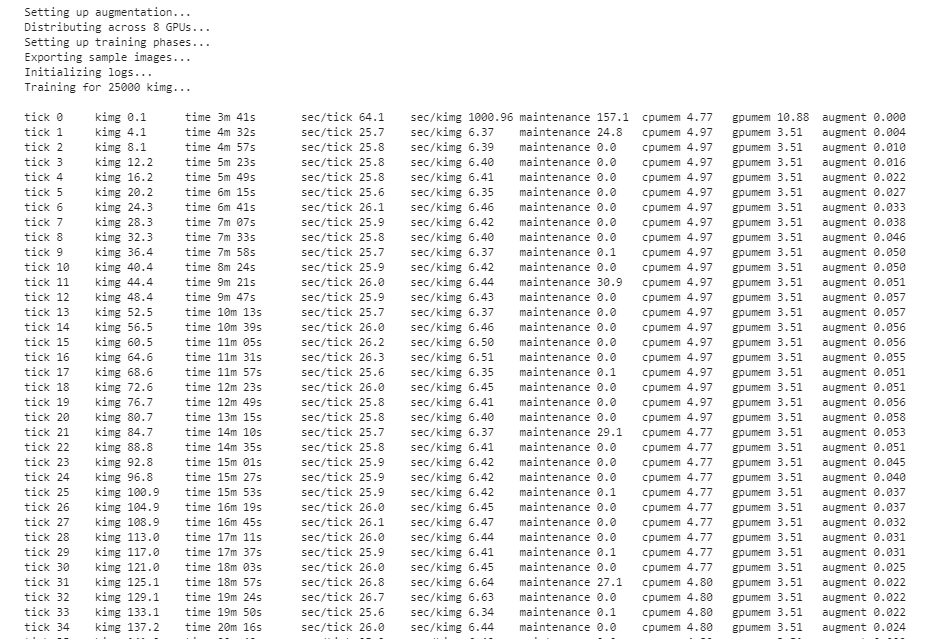

###학습이 진행되면 아래와 같이 로그가 남음

In [20]:
!ls 'results'

00000-promedius_cxr_500_for_stylegan2ada_128pixel-auto1-gamma10-bg-resumeffhq256


In [21]:
!ls 'results/00000-promedius_cxr_500_for_stylegan2ada_128pixel-auto1-gamma10-bg-resumeffhq256'

fakes000000.png  fakes000520.png	      network-snapshot-000280.pkl
fakes000040.png  fakes000560.png	      network-snapshot-000320.pkl
fakes000080.png  fakes000600.png	      network-snapshot-000360.pkl
fakes000120.png  fakes_init.png		      network-snapshot-000400.pkl
fakes000160.png  log.txt		      network-snapshot-000440.pkl
fakes000200.png  metric-fid50k_full.jsonl     network-snapshot-000480.pkl
fakes000240.png  network-snapshot-000000.pkl  network-snapshot-000520.pkl
fakes000280.png  network-snapshot-000040.pkl  network-snapshot-000560.pkl
fakes000320.png  network-snapshot-000080.pkl  network-snapshot-000600.pkl
fakes000360.png  network-snapshot-000120.pkl  reals.png
fakes000400.png  network-snapshot-000160.pkl  stats.jsonl
fakes000440.png  network-snapshot-000200.pkl  training_options.json
fakes000480.png  network-snapshot-000240.pkl


In [22]:
!ls 'handson_stylegan2ada'

promedius_cxr_500_for_stylegan2ada_128pixel
promedius_cxr_500_for_stylegan2ada_128pixel.zip


In [23]:
# 미리 학습해둔 weight 다운받기
!wget https://drive.promedius.dev/s/iG2yDnL4ToNHz4p/download/network-snapshot-011571.pkl

--2022-08-09 22:51:54--  https://drive.promedius.dev/s/iG2yDnL4ToNHz4p/download/network-snapshot-011571.pkl
Resolving drive.promedius.dev (drive.promedius.dev)... 112.169.219.65
Connecting to drive.promedius.dev (drive.promedius.dev)|112.169.219.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283134230 (270M) [application/octet-stream]
Saving to: ‘network-snapshot-011571.pkl’

network-snapshot-01 100%[===================>] 270.02M  24.9MB/s    in 12s     

2022-08-09 22:52:06 (22.8 MB/s) - ‘network-snapshot-011571.pkl’ saved [283134230/283134230]



In [24]:
!ls

calc_metrics.py  handson_stylegan2ada	      __pycache__
dataset_tool.py  handson_stylegan2ada.zip     README.md
dnnlib		 legacy.py		      results
Dockerfile	 LICENSE.txt		      style_mixing.py
docker_run.sh	 metrics		      torch_utils
docs		 network-snapshot-011571.pkl  training
generate.py	 projector.py		      train.py


In [25]:
#미리 학습해둔 weight로 합성 이미지 만들기(trunc: 합성 이미지의 분포 넓이. 0에 가까울수록 분포가 좁아짐. 1은 truncation을 사용하지 않은 것과 동일 효과)
!python generate.py --outdir generated_images --trunc=0.1 --seeds=10 --network 'network-snapshot-011571.pkl'

Loading networks from "network-snapshot-011571.pkl"...
Generating image for seed 10 (0/1) ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


In [26]:
#합성한 이미지 파일 체크해보기
os.listdir('generated_images')

['seed0010.png']

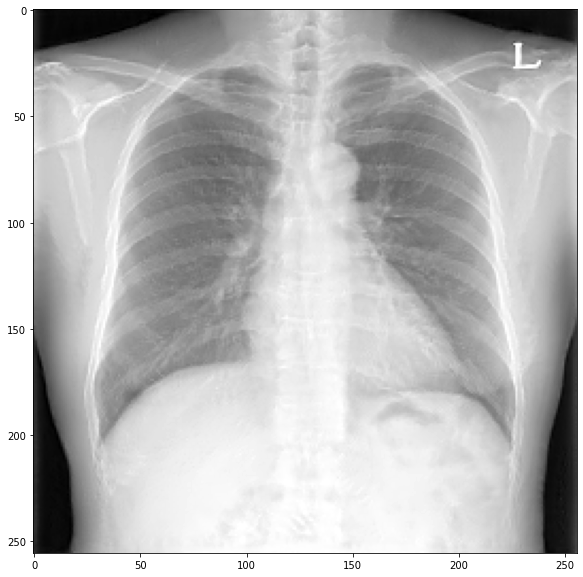

In [27]:
#합성한 이미지 디스플레이 해보기(참고: 학습이 충분히 되지 않음. 1024x1024-pixel 이미지를 생성시 StyleGAN2-ADA의 경우 GPU 24GB하나를 사용했을때 대략 2주일 정도 소요됨)
syn_img=cv2.imread('generated_images/seed0010.png', 0)
plt.figure(figsize=(10,10))
plt.imshow(syn_img, cmap='gray')
plt.show()